In [1]:
# Importing all the necessary libraries
import numpy as np
import pandas as pd
from collections import Counter
from datetime import datetime
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
import xgboost
from xgboost import plot_importance
from xgboost import XGBClassifier
import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import auc, roc_curve, classification_report
import math
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

#import sys
#!{sys.executable} -m pip install cufflinks
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
# import cufflinks and offline mode
import cufflinks as cf
cf.go_offline()

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from collections import Counter

from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping

C:\Users\yijia\anaconda3\envs\py3-TF2.0\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
user = pd.read_csv('user_table.csv')
data = pd.read_csv('test_table.csv')

In [3]:
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [4]:
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


### Goal
Company XYZ is a worldwide e-commerce site with localized versions of the site.
A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than
any other Spanish-speaking country. She therefore went and talked to the international team in
charge of Spain And LatAm to see if they had any ideas about why that was happening.

Spain and LatAm country manager suggested that one reason could be translation. All Spanish-speaking countries had the same translation of the site which was written by a Spaniard. They agreed to try a test where each country would have its one translation written by a local. That is, Argentinian users would see a translation written by an Argentinian, Mexican users by a Mexican and so on. Obviously, nothing would change for users from Spain.

After they run the test however, they are really surprised cause the test is negative. I.e., it
appears that the non-localized translation was doing better!

You are asked to:

- Confirm that the test is actually negative. That is, it appears that the old version of the 
site with just one translation across Spain and LatAm performs better
- Explain why that might be happening. Are the localized translations really worse?
- If you identified what was wrong, design an algorithm that would return FALSE if the
same problem is happening in the future and TRUE if everything is good and the results
can be trusted

In [5]:
# check duplicates
print ("There is no duplicates in test table: ", data['user_id'].nunique() == data.shape[0])
print ("There is no  duplicates in user table: ", user['user_id'].nunique() == user.shape[0])

There is no duplicates in test table:  True
There is no  duplicates in user table:  True


In [6]:
# check if everyone in one table also in other one?
data.user_id.nunique()-user.user_id.nunique()

454

In [7]:
# Merge two dataframe
df = pd.merge(left = data, right = user, how = 'left', on = 'user_id')
# or df = data.merge(user, on = 'user_id', how = 'left')


In [8]:
df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
user_id,453321.0,499937.514728,288665.193436,1.0,249816.0,500019.0,749522.0,1000000.0
conversion,453321.0,0.049579,0.217073,0.0,0.0,0.0,0.0,1.0
test,453321.0,0.476446,0.499445,0.0,0.0,0.0,1.0,1.0
age,452867.0,27.130740,6.776678,18.0,22.0,26.0,31.0,70.0


In [10]:
for col in df.select_dtypes(include='object'):
    uniques = df[col].unique()
    print('{0:20s}{1:2d}\t'.format(col, len(uniques)), uniques)

date                 5	 ['2015-12-03' '2015-12-04' '2015-11-30' '2015-12-01' '2015-12-02']
source               3	 ['Direct' 'Ads' 'SEO']
device               2	 ['Web' 'Mobile']
browser_language     3	 ['ES' 'Other' 'EN']
ads_channel          6	 [nan 'Google' 'Facebook' 'Bing' 'Yahoo' 'Other']
browser              7	 ['IE' 'Chrome' 'Android_App' 'FireFox' 'Iphone_App' 'Safari' 'Opera']
sex                  3	 ['M' 'F' nan]
country             18	 ['Spain' 'Mexico' 'Venezuela' 'Bolivia' 'Colombia' 'Uruguay' 'El Salvador'
 'Nicaragua' 'Peru' 'Costa Rica' 'Chile' 'Argentina' 'Ecuador' 'Guatemala'
 'Honduras' 'Paraguay' 'Panama' nan]


### A/B Test

#####  1. check whether spain converts better than the rest of LatAm countries

In [11]:
# control group: test == 0
groupby_country = df[df['test']==0].groupby('country')['conversion'].mean()
groupby_country = groupby_country.reset_index()
groupby_country = groupby_country.sort_values('conversion', ascending = False)

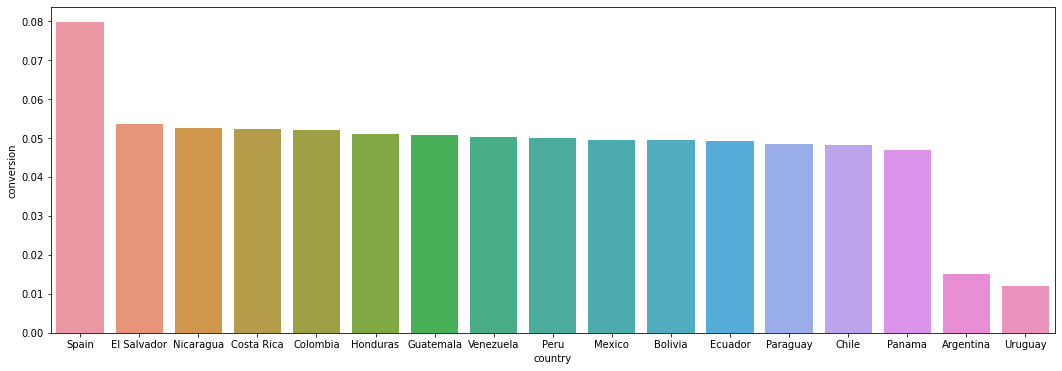

In [12]:
fig, ax = plt.subplots(figsize = (18, 6))
sns.barplot(x = 'country', y = 'conversion', data = groupby_country, ax = ax)
plt.show()

It looks like spain convert at least 2% more than the rest of LatAm countries

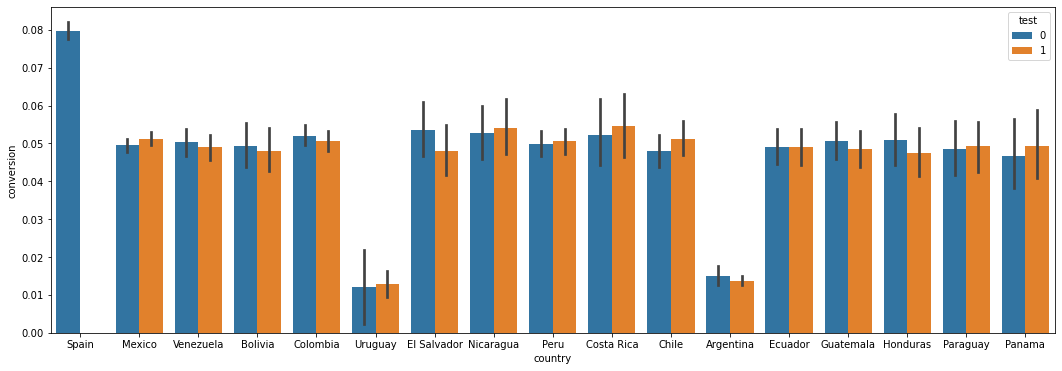

In [13]:
fig = plt.figure(figsize = (18, 6))
sns.barplot(x = 'country', y = 'conversion', hue = 'test', data = df)
plt.show()

In [14]:
#========================================================
# Two sample t-TEST
#========================================================
test_data = df[df['country']!='Spain'] #nothing changed in Spain, so no point in keeping those users
orig = test_data[test_data['test']==0]['conversion'].values
after = test_data[test_data['test']==1]['conversion'].values
print("Mean conversion rate of control group:", orig.mean())
print("Mean conversion rate of test group:", after.mean())


Mean conversion rate of control group: 0.04833042316066309
Mean conversion rate of test group: 0.043424713982118966


In [15]:
# 1 check the assumption of normality using the stats.shapiro()
from scipy.stats import shapiro
print(shapiro(orig))
print(shapiro(after))

from scipy.stats import normaltest
print(normaltest(orig))
print(normaltest(after))

ShapiroResult(statistic=0.21902984380722046, pvalue=0.0)
ShapiroResult(statistic=0.20420461893081665, pvalue=0.0)
NormaltestResult(statistic=153780.89625473792, pvalue=0.0)
NormaltestResult(statistic=188897.33269905322, pvalue=0.0)


C:\Users\yijia\anaconda3\envs\py3-TF2.0\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning:

p-value may not be accurate for N > 5000.



In [16]:
# Check equal variance
import scipy.stats
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-scipy.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f, p
  
# perform F-test
f_test(orig, after)

(1.1072635162311828, 1.1102230246251565e-16)

In [17]:
ttest_ind(after, orig, equal_var=True)

Ttest_indResult(statistic=-7.422512095954769, pvalue=1.15144687852198e-13)

In control the converting rate is 4.8% while 4.3% for the test group. It seems that local-translation make it even worse, i.e., 10% drop, which would be dramatic if it were true. 

The most likely reason for weired A/B test results are:
1. we didn't collect enough data
2. some bias has been introduced in the experiment so that test/control are not really random. 

###### In data science, whenever results appear too bad or too good to be true, they are not true.

Firstly, we can plot day to day, to see if these weired results have been constantly happening or they just started happening all of a sudden.

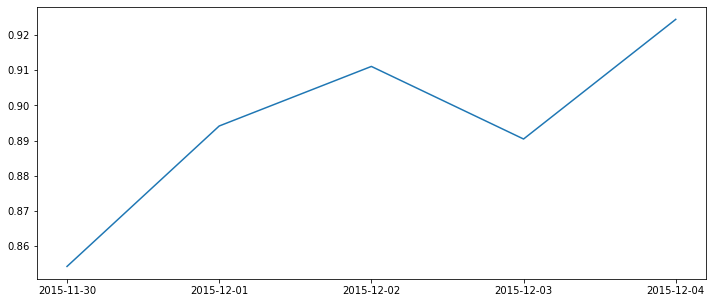

In [18]:
orig_bydate = test_data[test_data['test'] == 0].groupby('date')['conversion'].mean()
after_bydate = test_data[test_data['test'] == 1].groupby('date')['conversion'].mean()
fig = plt.figure(figsize = (12, 5))
plt.plot(after_bydate/orig_bydate)
plt.show()

From the plot above, we notice: 
- Test has constantly been worse than control and there is relatively little across days. That probably means that we do have enough data, but there was some bias in the experiment set up. 
- On a side note, we just ran it for 5 days. We should always run the test at least 1 full week to capture weekly patterns, 2 weeks should be much better. 

###### Try find the selection bias
In an ideal world, the distribution of people in test and control for each segment should be the same.  To check wehter it is true, we can:
Build a decision tree where the variables are the user attributes and the outcome variable is whether the user is in test or control. If the tree splits, it means for given values of that variable, the user is more likely to end up in test/contro. But this should be impossible. That is, if the randomization worked, the tree should not split at all. 

In [19]:
tree_data = test_data.dropna(how='any',axis=0) 

In [20]:
# One-Hot-Encoding for Categorical Data
def OneHotEncoding(d):
    col_name = d.columns
    for i in range(d.shape[1]):
        dummy = pd.get_dummies(d[col_name[i]], prefix=col_name[i], drop_first=True)
        d = pd.concat([d, dummy], axis=1)
        d = d.drop(col_name[i], axis=1)
    return d

def DataTransformation(data):
    cat = data.select_dtypes(include = ['object'])
    cat_new = OneHotEncoding(cat)
    newdata = pd.concat([data.drop(cat,axis=1), cat_new], axis=1)
    return newdata

In [23]:
X_train = tree_data.drop(['user_id','date', 'test','conversion'], axis=1)
y_train = tree_data['test']

X_train_trans = DataTransformation(X_train)
X_train_trans.head()

,age,device_Web,browser_language_ES,browser_language_Other,ads_channel_Facebook,ads_channel_Google,ads_channel_Other,ads_channel_Yahoo,browser_Chrome,browser_FireFox,...,country_El Salvador,country_Guatemala,country_Honduras,country_Mexico,country_Nicaragua,country_Panama,country_Paraguay,country_Peru,country_Uruguay,country_Venezuela
1,21.0,1,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,22.0,0,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,19.0,1,1,0,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
9,33.0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
10,37.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier(max_depth=3)
dtree.fit(X_train_trans, y_train)

DecisionTreeClassifier(max_depth=3)

[Text(0.5, 0.875, 'X[28] <= 0.5\ngini = 0.497\nsamples = 160800\nvalue = [74352, 86448]'),
 Text(0.25, 0.625, 'X[23] <= 0.5\ngini = 0.498\nsamples = 159144\nvalue = [74198, 84946]'),
 Text(0.125, 0.375, 'X[17] <= 0.5\ngini = 0.495\nsamples = 107387\nvalue = [48514, 58873]'),
 Text(0.0625, 0.125, 'gini = 0.492\nsamples = 85917\nvalue = [37666, 48251]'),
 Text(0.1875, 0.125, 'gini = 0.5\nsamples = 21470\nvalue = [10848, 10622]'),
 Text(0.375, 0.375, 'X[0] <= 54.5\ngini = 0.5\nsamples = 51757\nvalue = [25684, 26073]'),
 Text(0.3125, 0.125, 'gini = 0.5\nsamples = 51723\nvalue = [25673, 26050]'),
 Text(0.4375, 0.125, 'gini = 0.438\nsamples = 34\nvalue = [11, 23]'),
 Text(0.75, 0.625, 'X[0] <= 25.5\ngini = 0.169\nsamples = 1656\nvalue = [154, 1502]'),
 Text(0.625, 0.375, 'X[2] <= 0.5\ngini = 0.139\nsamples = 797\nvalue = [60, 737]'),
 Text(0.5625, 0.125, 'gini = 0.084\nsamples = 136\nvalue = [6, 130]'),
 Text(0.6875, 0.125, 'gini = 0.15\nsamples = 661\nvalue = [54, 607]'),
 Text(0.875, 0.375

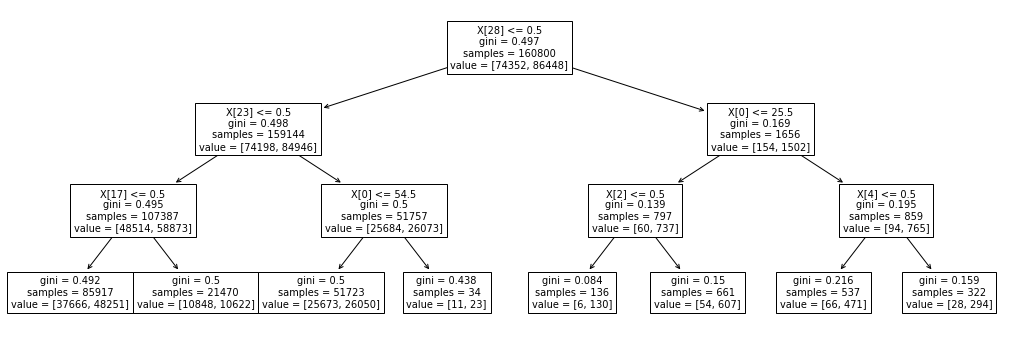

In [25]:
from sklearn.datasets import load_iris
from sklearn import tree
fig = plt.figure(figsize=(18,6))
tree.plot_tree(dtree)

From the features, we can see that countries is the most important feature for conversion. So let’s check the test results after controlling for country.

In [26]:
countries = [name for name in test_data['country'].unique() if name is not np.nan]

In [27]:
print('{0:15s}{1:>15s}{2:>15s}{3:>10s}'.format('Country','Test Rate', 'Control Rate', 'P-value'))
print('-'*65)
for country in countries:
    test_val = test_data[(test_data['country'] == country) & (test_data['test'] == 1)]['conversion'].values
    cont_val = test_data[(test_data['country'] == country) & (test_data['test'] == 0)]['conversion'].values
    
    test_mean = test_val.mean()
    cont_mean = cont_val.mean()
    p_val = ttest_ind(test_val, cont_val, equal_var=False).pvalue
    
    print('{0:10s} {1:15.5f} {2:15.5f} {3:15f}'.format(country, test_mean, cont_mean, p_val))

Country              Test Rate   Control Rate   P-value
-----------------------------------------------------------------
Mexico             0.05119         0.04949        0.165544
Venezuela          0.04898         0.05034        0.573702
Bolivia            0.04790         0.04937        0.718885
Colombia           0.05057         0.05209        0.423719
Uruguay            0.01291         0.01205        0.879764
El Salvador         0.04795         0.05355        0.248127
Nicaragua          0.05418         0.05265        0.780400
Peru               0.05060         0.04991        0.771953
Costa Rica         0.05474         0.05226        0.687876
Chile              0.05130         0.04811        0.302848
Argentina          0.01373         0.01507        0.335147
Ecuador            0.04899         0.04915        0.961512
Guatemala          0.04865         0.05064        0.572107
Honduras           0.04754         0.05091        0.471463
Paraguay           0.04923         0.04849        0

After we control for country, the test clearly appears non significant. Not a great success given that the goal was to improve conversion rate, but at least we know that a localized translation didn’t make things worse!

In [28]:
t_test_df = df[['age', 'test']].dropna()
cat1 = t_test_df[t_test_df.test == 1].age
cat2 = t_test_df[t_test_df.test == 0].age

ttest, p =ttest_ind(cat1, cat2)
print ('t-test independent', ttest)
print (p)

t-test independent -1.4687728655994179
0.14189510075984352


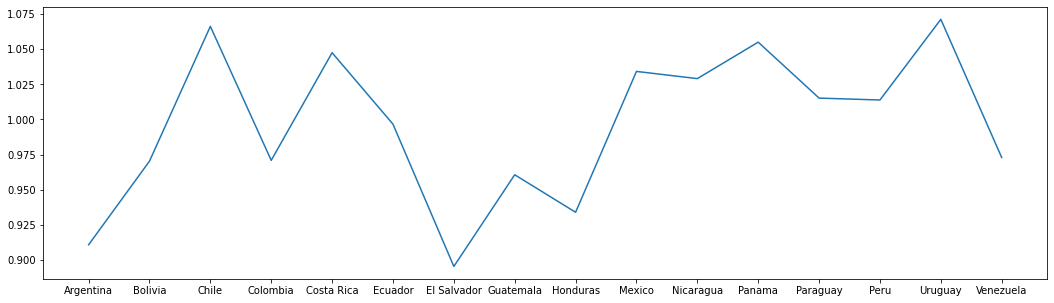

In [29]:
orig_bycountry = test_data[test_data['test']==0].groupby('country')['conversion'].mean()
after_bycountry = test_data[test_data['test']==1].groupby('country')['conversion'].mean()
fig = plt.figure(figsize=(18,5))
plt.plot(after_bycountry/orig_bycountry)
plt.show()

In [64]:
# fit a random forest to see the importance feature
# build model
#We are performing a numerical encoding to the categorical features, using the sklearn label encoder.
from sklearn.preprocessing import LabelEncoder
comp_df = df.dropna(subset=['sex'])
for feature in df.select_dtypes(include='object'):
    lbl_enc = LabelEncoder()
    lbl_enc.fit(comp_df[feature])
    comp_df[feature] = lbl_enc.transform(comp_df[feature])
    if feature == 'country':
        coun = list(lbl_enc.inverse_transform(comp_df[feature]))

In [72]:
#Fit a Random Forest and check feature importance
#datatype = df.dtypes
#feature = datatype[(datatype == 'object') | (datatype == 'category')].index.tolist()
feature = ['browser_language', 'country', 'browser', 'ads_channel', 'device', 'source', 'sex', 'age']
model = RandomForestClassifier() # or DecisionTreeClassifier()
#model.fit(map(lambda x: [x],comp_df[features]),comp_df['test'])
model.fit(comp_df[feature], comp_df['test'])
feature_importances = model.feature_importances_

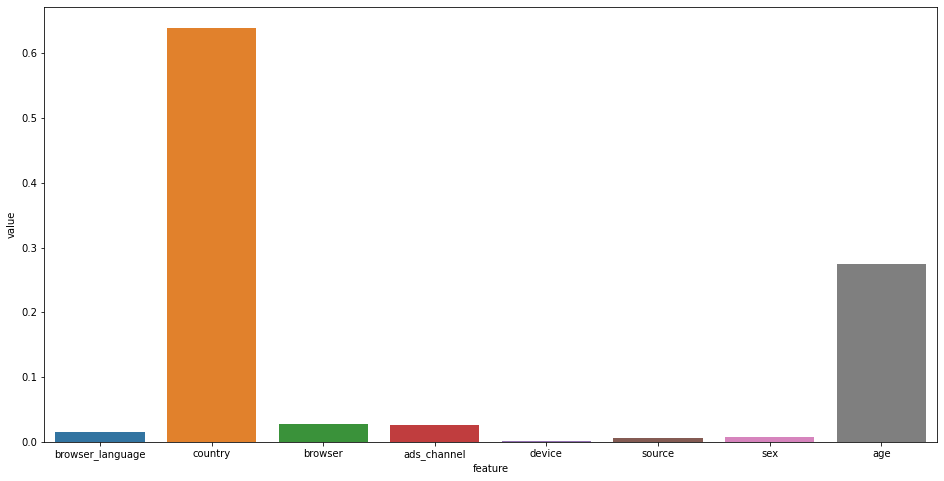

In [73]:
columns = ['feature', 'value']
importance = pd.DataFrame(feature_importances, index=feature).reset_index()
importance.columns = columns
fig = plt.figure(figsize = (16, 8))
sns.barplot(x='feature', y ='value', data=importance)
plt.show()

NameError: name 'clf' is not defined